In [13]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/DL/Mpox'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization, AveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:

if not os.path.exists(data_dir):
    print(f"FATAL ERROR: The directory '{data_dir}' was not found. Please check your path.")
else:
    print(f"Base data directory found: {data_dir}")

file_directory = os.listdir(data_dir)
images_file = []
labels_of_img = []
valid_extensions = ['png', 'jpg', 'jpeg']
expected_dirs = ['Monkeypox', 'Normal', 'Others']
found_expected = [d for d in file_directory if d in expected_dirs]

if not found_expected:
    print(f"WARNING: No expected subdirectories ({', '.join(expected_dirs)}) found in {data_dir}.")
    print("Ensure 'Monkeypox', 'Normal', and 'Others' are directly inside the 'Mpox' folder.")

for directory in found_expected:
    full_dir_path = os.path.join(data_dir, directory)
    if os.path.isdir(full_dir_path):
        try:
            image_paths = os.listdir(full_dir_path)
            for img_name in image_paths:
                extension = img_name.split('.')[-1].lower()
                if extension in valid_extensions:
                    images_file.append(os.path.join(full_dir_path, img_name))
                    labels_of_img.append(directory)
        except Exception as e:
            print(f"Error listing files in {full_dir_path}: {e}")

dataframe = {"images": images_file, "labels": labels_of_img}
data = pd.DataFrame(dataframe)

if data.empty:
    print("\nFATAL ERROR: DataFrame is empty. No image paths were collected.")
else:
    print(f"\nCollected {len(data)} image paths. Processing...")

Base data directory found: /content/drive/MyDrive/DL/Mpox

Collected 769 image paths. Processing...


In [16]:
images = []
shape = (224, 224)
successful_paths = []

for index, path in data['images'].items():
    try:
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, shape)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        successful_paths.append(path)
    except Exception as e:
        print(f"Error processing image {path}: {e}. Skipping.")

images = np.array(images)

# Rebuild labels based on successful paths
data_successful = data[data['images'].isin(successful_paths)].reset_index(drop=True)
labels = pd.get_dummies(data_successful['labels']).values
classes = pd.get_dummies(data_successful['labels']).columns.tolist()

if images.size == 0:
    print("\nFATAL ERROR: Final images array is empty after loading attempts. Cannot proceed.")
else:
    print(f"Total images loaded: {images.shape[0]}")
    print(f"Labels shape: {labels.shape}")


Total images loaded: 769
Labels shape: (769, 3)


In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    images, labels, random_state=42, test_size=0.2, shuffle=True
)

X_train_scaled = x_train / 255.0
X_test_scaled = x_test / 255.0

In [18]:
from tensorflow.keras.utils import set_random_seed
set_random_seed(0)

In [19]:
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

# Dense layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(len(classes), activation='softmax'))

print("\n--- Model Summary ---")
model.summary()
print("---------------------\n")


--- Model Summary ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 112, 112, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 56, 56, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 28, 28, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,476,419 (196.37 MB)

 Trainable params: 51,475,971 (196.37 MB)

 Non-trainable params: 448 (1.75 KB)

---------------------



In [20]:
#Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)



datagen.fit(X_train_scaled)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=['accuracy']
)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)
callbacks_list = [es, lr_scheduler]


In [21]:

print("\nStarting model training with Data Augmentation, LR Scheduling, and Average Pooling...")

history = model.fit(
    datagen.flow(X_train_scaled, y_train, batch_size=15),
    epochs=30,
    verbose=1,
    validation_data=(X_test_scaled, y_test),
    callbacks=callbacks_list
)


Starting model training with Data Augmentation, LR Scheduling, and Average Pooling...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 207ms/step - accuracy: 0.4529 - loss: 16.8153 - val_accuracy: 0.3636 - val_loss: 3.2869 - learning_rate: 5.0000e-04
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.4857 - loss: 15.1193 - val_accuracy: 0.3896 - val_loss: 4.7896 - learning_rate: 5.0000e-04
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.5214 - loss: 2.5092 - val_accuracy: 0.3896 - val_loss: 3.8931 - learning_rate: 5.0000e-04
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.5225 - loss: 1.1509
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.5231 - loss: 1.1481 - val_accuracy: 0.3052 - val_loss: 4.3858 - learning_rate: 5.0000e-04
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.5737 - loss: 1.0490 - val_accuracy: 0.3052 - val_loss: 4.0521 - learning_rate: 2.5000e-04
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.

Test Loss: 0.6313
Test Accuracy: 0.7403
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step

Confusion Matrix:
[[51  0  5]
 [ 9 48  3]
 [16  7 15]]
Classes: ['Monkeypox', 'Normal', 'Others']


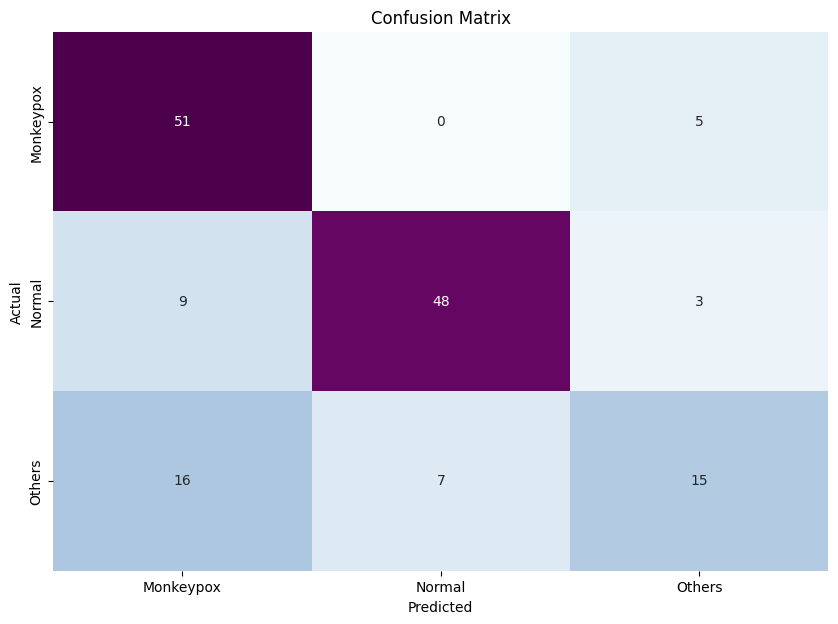


Classification Report:
              precision    recall  f1-score   support

   Monkeypox     0.6711    0.9107    0.7727        56
      Normal     0.8727    0.8000    0.8348        60
      Others     0.6522    0.3947    0.4918        38

    accuracy                         0.7403       154
   macro avg     0.7320    0.7018    0.6998       154
weighted avg     0.7450    0.7403    0.7276       154



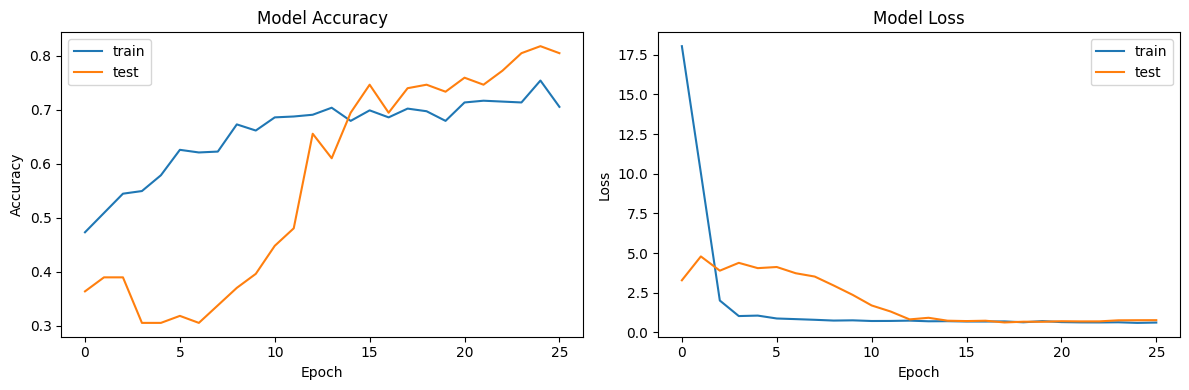

In [22]:

loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Y_pred_raw = model.predict(X_test_scaled)
Y_pred = np.argmax(Y_pred_raw, axis=1)
y_test_arg = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_arg, Y_pred)
print("\nConfusion Matrix:")
print(cm)
print(f"Classes: {classes}")

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='BuPu', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test_arg, Y_pred, target_names=classes, digits=4))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

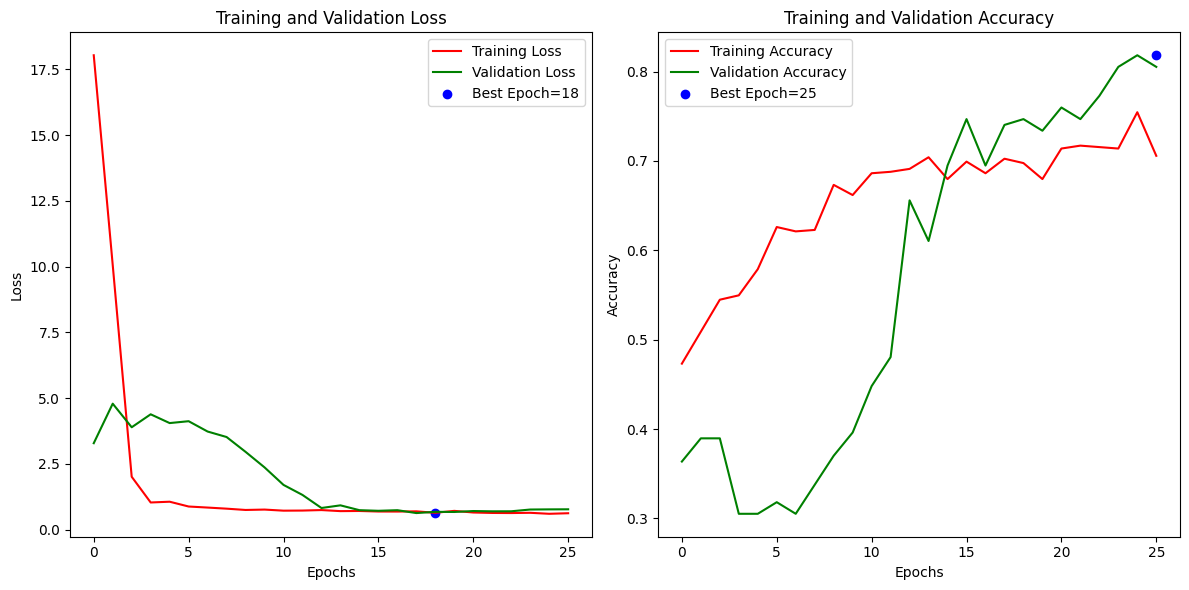

In [23]:
import matplotlib.pyplot as plt



# Extracting the loss and accuracy data
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Find the epoch with the best validation accuracy and the best validation loss
best_epoch_accuracy = val_accuracy.index(max(val_accuracy)) + 1
best_epoch_loss = val_loss.index(min(val_loss)) + 1

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plot 1: Loss (Training vs Validation)
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='red')
plt.plot(val_loss, label='Validation Loss', color='green')
plt.scatter(best_epoch_loss, val_loss[best_epoch_loss - 1], color='blue', label=f'Best Epoch={best_epoch_loss}')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot 2: Accuracy (Training vs Validation)
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy', color='red')
plt.plot(val_accuracy, label='Validation Accuracy', color='green')
plt.scatter(best_epoch_accuracy, val_accuracy[best_epoch_accuracy - 1], color='blue', label=f'Best Epoch={best_epoch_accuracy}')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()
